In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import matplotlib.pyplot as plt
import cv2 as cv

# Data preprocessing

In [3]:
batch_size=32
IMG_SIZE=(512,512)
train_ds=tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/coloncancer-train-val/train',
                                                            color_mode='rgb',
                                                             shuffle=True,
                                                             image_size=IMG_SIZE,
                                                             batch_size=batch_size,
                                                            seed=2023)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/coloncancer-train-val/validation",
    
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    seed=2023)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


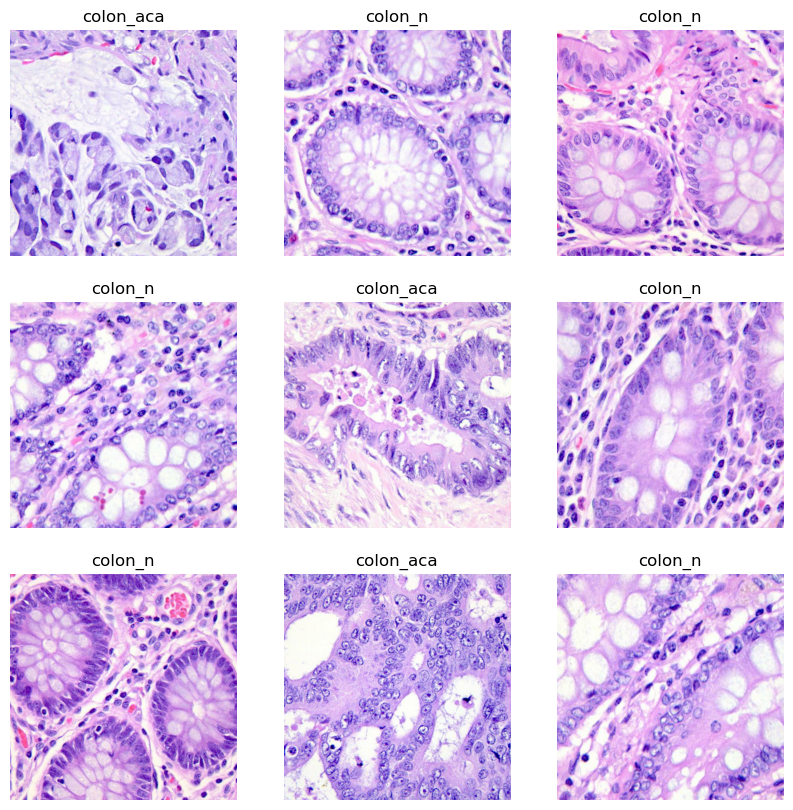

In [4]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches=tf.data.experimental.cardinality(val_ds)
test_ds=val_ds.take(val_batches//2)
val_ds=val_ds.skip(val_batches//2)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 32
Number of test batches: 31


# Configure dataset for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation

In [8]:
data_augmentation=tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal','vertical'),
                                      tf.keras.layers.RandomRotation(30),
                                      tf.keras.layers.RandomZoom(0.3),
                                      tf.keras.layers.RandomBrightness(0.2)])

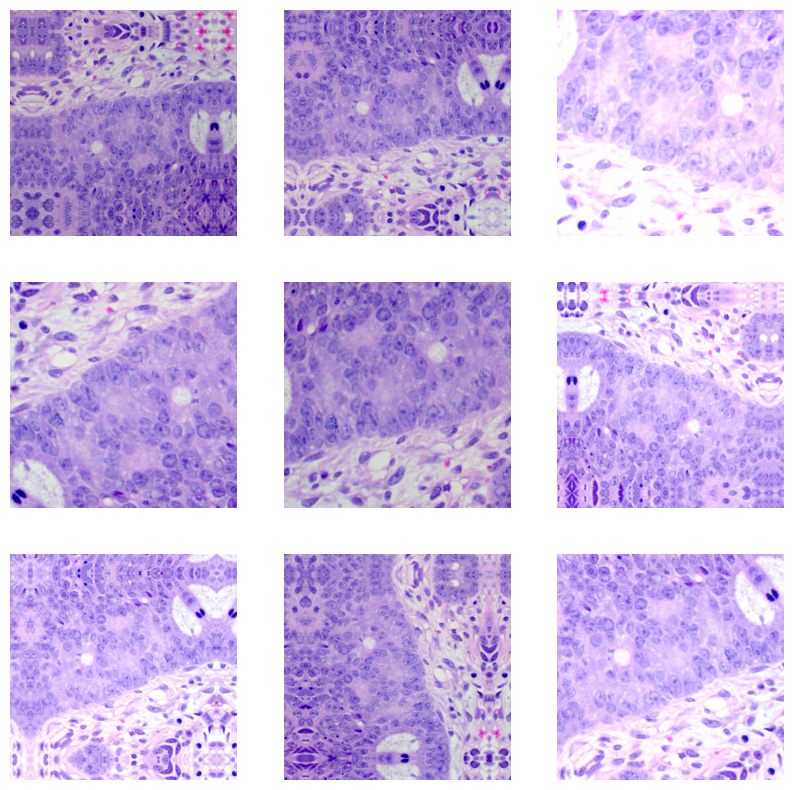

In [9]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
rescale=tf.keras.layers.Rescaling(1./255)

# Train a model

In [11]:
# Define the input shape
input_shape=(512,512,3)
model = tf.keras.Sequential([ data_augmentation,
                             rescale,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu',input_shape=input_shape),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')                            
])

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.binary_crossentropy,
  metrics=['accuracy'])

In [13]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
250/250 [==============================] - 130s 462ms/step - loss: 0.6936 - accuracy: 0.5027 - val_loss: 0.6930 - val_accuracy: 0.5179
Epoch 2/10
250/250 [==============================] - 114s 451ms/step - loss: 0.6933 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.4911
Epoch 3/10
250/250 [==============================] - 122s 479ms/step - loss: 0.6932 - accuracy: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 4/10
250/250 [==============================] - 122s 482ms/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.5159
Epoch 5/10
250/250 [==============================] - 122s 482ms/step - loss: 0.6932 - accuracy: 0.4818 - val_loss: 0.6931 - val_accuracy: 0.5159
Epoch 6/10
250/250 [==============================] - 114s 451ms/step - loss: 0.6932 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 7/10
250/250 [==============================] - 121s 477ms/step - loss: 0.6932 - accuracy: 0.4877 - val_loss: 0.6931 -

# Visualizing results

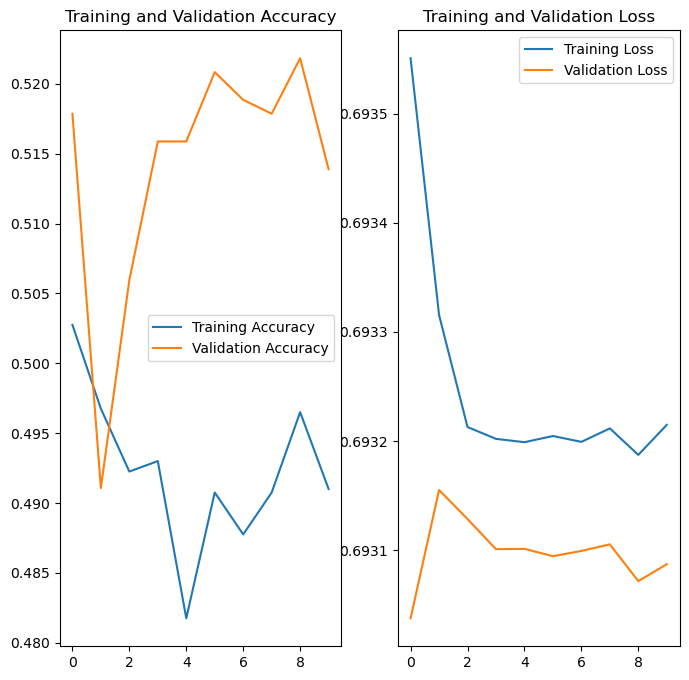

In [14]:
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluation and prediction

In [15]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

31/31 [==============================] - 8s 210ms/step - loss: 0.6932 - accuracy: 0.4940
Test accuracy : 0.49395161867141724


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1]


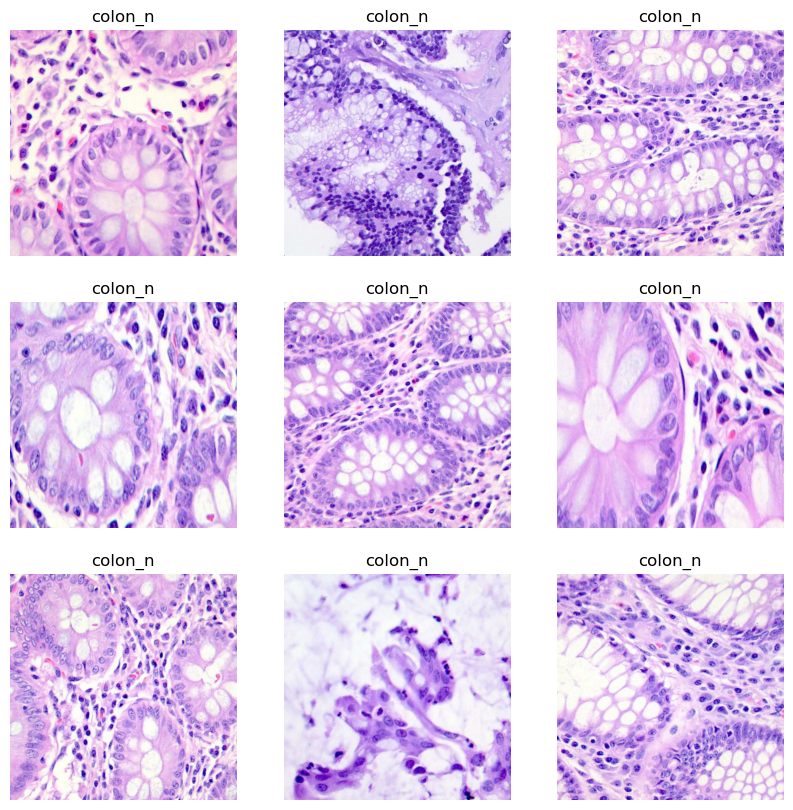

In [16]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Summary 

Model doesn't seem to learn anything and just predicts everything as normal.

# Transfer learning

## MobileNet V2 

In [17]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 16, 16, 1280)


In [19]:
base_model.trainable=False

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
#x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 16, 16, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1281  

In [26]:
len(model.trainable_variables)

2

# Train the model

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

32/32 [==============================] - 16s 212ms/step - loss: 4.9507 - accuracy: 0.5248


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.95
initial accuracy: 0.52


In [29]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
250/250 [==============================] - 135s 508ms/step - loss: 2.4904 - accuracy: 0.5486 - val_loss: 0.8208 - val_accuracy: 0.5813
Epoch 2/10
250/250 [==============================] - 128s 505ms/step - loss: 2.1827 - accuracy: 0.5727 - val_loss: 0.7591 - val_accuracy: 0.6111
Epoch 3/10
250/250 [==============================] - 129s 507ms/step - loss: 2.0512 - accuracy: 0.5869 - val_loss: 0.7280 - val_accuracy: 0.6627
Epoch 4/10
250/250 [==============================] - 128s 506ms/step - loss: 1.9420 - accuracy: 0.6087 - val_loss: 0.6402 - val_accuracy: 0.6855
Epoch 5/10
250/250 [==============================] - 128s 506ms/step - loss: 1.9619 - accuracy: 0.6235 - val_loss: 3.6984 - val_accuracy: 0.5337
Epoch 6/10
250/250 [==============================] - 131s 518ms/step - loss: 2.8948 - accuracy: 0.5990 - val_loss: 1.0506 - val_accuracy: 0.6696
Epoch 7/10
250/250 [==============================] - 129s 510ms/step - loss: 1.9119 - accuracy: 0.6344 - val_loss: 0.7614 -

# Learning curves

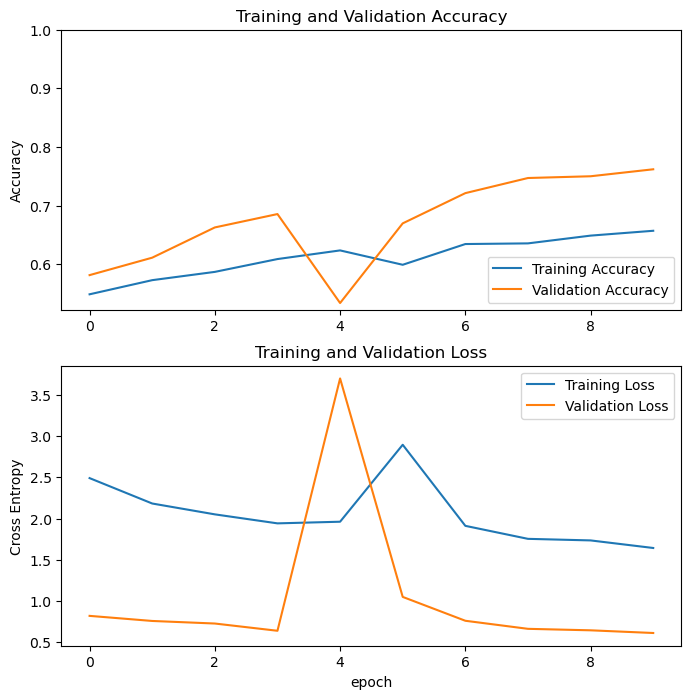

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [31]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

31/31 [==============================] - 8s 229ms/step - loss: 0.5335 - accuracy: 0.7651
Test accuracy : 0.7651209831237793


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1]
Labels:
 [0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1]


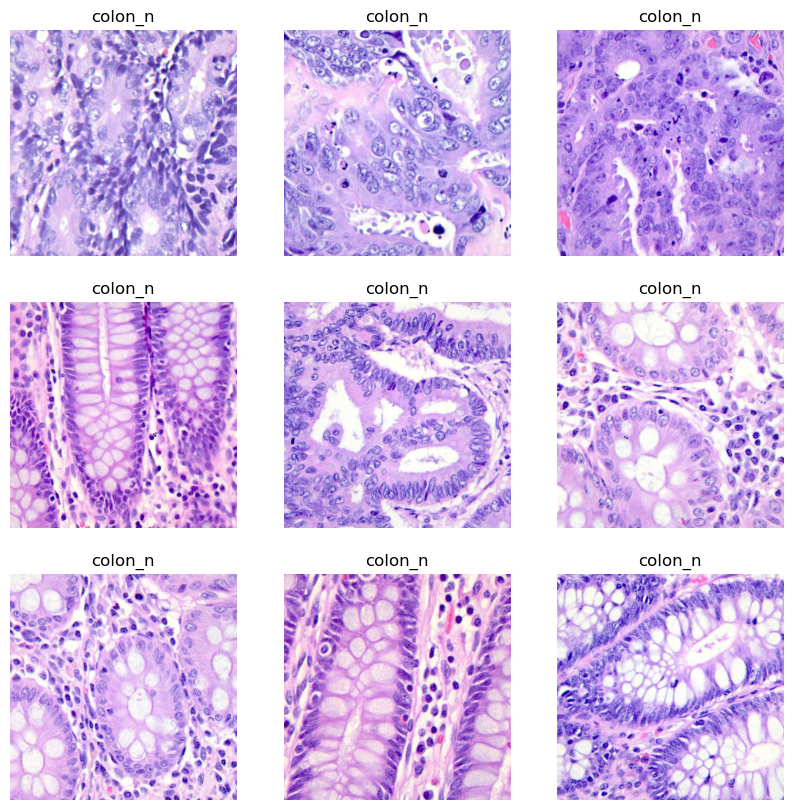

In [32]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")